In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import confusion_matrix

c:\Users\Rajan Patel\anaconda3\envs\py310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Rajan Patel\anaconda3\envs\py310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\Rajan Patel\anaconda3\envs\py310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Save to df
applications = pd.read_csv("../Project4_data/Resources/application_record.csv", encoding = 'utf-8')
record = pd.read_csv("../Project4_Data/Resources/credit_record.csv", encoding = 'utf-8')

# Shape and preview
print('Application record df shape:', applications.shape)
applications.head()

Application record df shape: (438557, 18)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [3]:
# Shape and preview
print('Credit record df shape:', record.shape)
record.head()

Credit record df shape: (1048575, 3)


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [4]:
applications.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [5]:
record.isna().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [6]:
print(f'Duplicates in applications df: {applications.iloc[:,1:].duplicated().sum()}')
print('')
print(f'Duplicates in record df: {record.duplicated().sum()}')

Duplicates in applications df: 348472

Duplicates in record df: 0


In [7]:
applications.nunique()

ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64

Data Clean

In [8]:
# Drop duplicates
applications=applications.drop_duplicates(subset=applications.columns[1:], keep='first')

In [9]:
# Fill missing values
applications['OCCUPATION_TYPE'].fillna(value='Other', inplace=True)

In [10]:
# Drop constant feature, not useful
applications.drop('FLAG_MOBIL', axis=1, inplace=True)


Create target variable

Because the credit records are incomplete (the ID ranges in both dfs don't match) we have to create our own target. We do this by identifying 'low risk' and 'high risk' credit users. We say a user is 'high risk' if during any month they are late on payments by 30 days or more, and 'low risk' otherwise. This is the target we will try to predict later.

In [11]:
# Construct target
record['target']=record['STATUS']
record['target'].replace('X', 0, inplace=True)
record['target'].replace('C', 0, inplace=True)
record['target']=record['target'].astype(int)
record.loc[record['target']>=1,'target']=1

# target=1 (high risk) if there is at least one month where user is late on payments by 30 days or more
target_df=pd.DataFrame(record.groupby(['ID'])['target'].agg(max)).reset_index()

# Merge dataframes
new_df=pd.merge(applications, target_df, how='inner', on=['ID'])

Number of months the account is open correlates with the customer's riskiness (More chances to miss payments)

In [12]:
# Extract how many months account has been open for
start_df=pd.DataFrame(record.groupby(['ID'])['MONTHS_BALANCE'].agg(min)).reset_index()

# Rename column
start_df.rename(columns={'MONTHS_BALANCE':'ACCOUNT_LENGTH'}, inplace=True)

# Make entries positive
start_df['ACCOUNT_LENGTH']=-start_df['ACCOUNT_LENGTH']

# Merge dataframes on ID
new_df=pd.merge(new_df, start_df, how='inner', on=['ID'])

In [13]:
# Create age feature
new_df['AGE_YEARS']=-new_df['DAYS_BIRTH']/365.2425
new_df.drop('DAYS_BIRTH', axis=1, inplace=True)

# Create unemployed indicator
new_df['UNEMPLOYED']=0
new_df.loc[-new_df['DAYS_EMPLOYED']<0,'UNEMPLOYED']=1

# Create years employed feature
new_df['YEARS_EMPLOYED']=-new_df['DAYS_EMPLOYED']/365.2425
new_df.loc[new_df['YEARS_EMPLOYED']<0,'YEARS_EMPLOYED']=0
new_df.drop('DAYS_EMPLOYED', axis=1, inplace=True)

In [14]:
# Encode binary features
new_df["CODE_GENDER"] =  new_df["CODE_GENDER"].replace(['F','M'],[0,1])
new_df["FLAG_OWN_CAR"] = new_df["FLAG_OWN_CAR"].replace(["Y","N"],[1,0])
new_df["FLAG_OWN_REALTY"] = new_df["FLAG_OWN_REALTY"].replace(["Y","N"],[1,0])

In [15]:
new_df = new_df.rename(columns={'CODE_GENDER': 'Gender', 'FLAG_OWN_CAR': 'Own_car', 
                               'FLAG_OWN_REALTY':'Own_property','CNT_CHILDREN':'Num_children',
                               'AMT_INCOME_TOTAL':'Total_income','NAME_INCOME_TYPE':'Income_type',
                               'NAME_EDUCATION_TYPE':'Education_type','NAME_FAMILY_STATUS':'Family_status',
                               'NAME_HOUSING_TYPE':'Housing_type','FLAG_WORK_PHONE':'Work_phone',
                               'FLAG_PHONE':'Phone','FLAG_EMAIL':'Email','OCCUPATION_TYPE':'Occupation_type',
                               'CNT_FAM_MEMBERS':'Num_family','target':'Target','ACCOUNT_LENGTH':'Account_length',
                                'AGE_YEARS':'Age','UNEMPLOYED':'Unemployed','YEARS_EMPLOYED':'Years_employed'})

In [16]:
new_df['Num_family']=new_df['Num_family'].astype(int)

In [17]:
new_df.columns

Index(['ID', 'Gender', 'Own_car', 'Own_property', 'Num_children',
       'Total_income', 'Income_type', 'Education_type', 'Family_status',
       'Housing_type', 'Work_phone', 'Phone', 'Email', 'Occupation_type',
       'Num_family', 'Target', 'Account_length', 'Age', 'Unemployed',
       'Years_employed'],
      dtype='object')

In [18]:
# Reordering
new_df=new_df[['ID', 'Gender', 'Own_car', 'Own_property', 'Work_phone',
               'Phone', 'Email', 'Unemployed', 'Num_children', 'Num_family', 
               'Account_length', 'Total_income', 'Age', 'Years_employed',  
               'Income_type', 'Education_type', 'Family_status',
               'Housing_type', 'Occupation_type','Target']]

In [19]:
print('Merged df shape:', new_df.shape)
new_df.head()

Merged df shape: (9709, 20)


,ID,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type,Target
0,5008804,1,1,1,1,0,0,0,0,2,15,427500.0,32.868574,12.435574,Working,Higher education,Civil marriage,Rented apartment,Other,1
1,5008806,1,1,1,0,0,0,0,0,2,29,112500.0,58.793815,3.104787,Working,Secondary / secondary special,Married,House / apartment,Security staff,0
2,5008808,0,0,1,0,1,1,0,0,1,4,270000.0,52.321403,8.353354,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,0
3,5008812,0,0,1,0,0,0,1,0,1,20,283500.0,61.504343,0.000000,Pensioner,Higher education,Separated,House / apartment,Other,0
4,5008815,1,1,1,1,1,1,0,0,2,5,270000.0,46.193967,2.105450,Working,Higher education,Married,House / apartment,Accountants,0


In [20]:
new_df.dtypes

ID                   int64
Gender               int64
Own_car              int64
Own_property         int64
Work_phone           int64
Phone                int64
Email                int64
Unemployed           int64
Num_children         int64
Num_family           int32
Account_length       int64
Total_income       float64
Age                float64
Years_employed     float64
Income_type         object
Education_type      object
Family_status       object
Housing_type        object
Occupation_type     object
Target               int32
dtype: object

In [21]:
# Save cleaned dataset
new_df.to_csv('clean_data.csv',index=False)

In [22]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9709 entries, 0 to 9708
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               9709 non-null   int64  
 1   Gender           9709 non-null   int64  
 2   Own_car          9709 non-null   int64  
 3   Own_property     9709 non-null   int64  
 4   Work_phone       9709 non-null   int64  
 5   Phone            9709 non-null   int64  
 6   Email            9709 non-null   int64  
 7   Unemployed       9709 non-null   int64  
 8   Num_children     9709 non-null   int64  
 9   Num_family       9709 non-null   int32  
 10  Account_length   9709 non-null   int64  
 11  Total_income     9709 non-null   float64
 12  Age              9709 non-null   float64
 13  Years_employed   9709 non-null   float64
 14  Income_type      9709 non-null   object 
 15  Education_type   9709 non-null   object 
 16  Family_status    9709 non-null   object 
 17  Housing_type  

In [23]:
#Looking to see if there is any influence of occupation type on credit card eligibility
occupation_eligible = new_df[new_df['Target'] == 1]['Occupation_type'].value_counts()
occupation_not_eligible = new_df[new_df['Target'] == 0]['Occupation_type'].value_counts()

print("Occupation Type and Credit Card Eligibility:")
print(f"Eligible for a Credit Card:\n{occupation_eligible}")

Occupation Type and Credit Card Eligibility:
Eligible for a Credit Card:
Occupation_type
Other                    370
Laborers                 225
Core staff               128
Managers                 111
Sales staff              110
Drivers                   89
High skill tech staff     50
Medicine staff            45
Accountants               39
Security staff            30
Cooking staff             28
Cleaning staff            20
Low-skill Laborers        11
Private service staff     10
Secretaries                5
Waiters/barmen staff       5
HR staff                   3
Realty agents              2
IT staff                   2
Name: count, dtype: int64


In [24]:
print(f"Not Eligible for a Credit Card:\n{occupation_not_eligible}")

Not Eligible for a Credit Card:
Occupation_type
Other                    2624
Laborers                 1499
Sales staff               849
Core staff                749
Managers                  671
Drivers                   534
High skill tech staff     307
Accountants               261
Medicine staff            246
Cooking staff             165
Security staff            152
Cleaning staff            126
Private service staff      76
Low-skill Laborers         42
Secretaries                41
Waiters/barmen staff       35
HR staff                   19
IT staff                   16
Realty agents              14
Name: count, dtype: int64


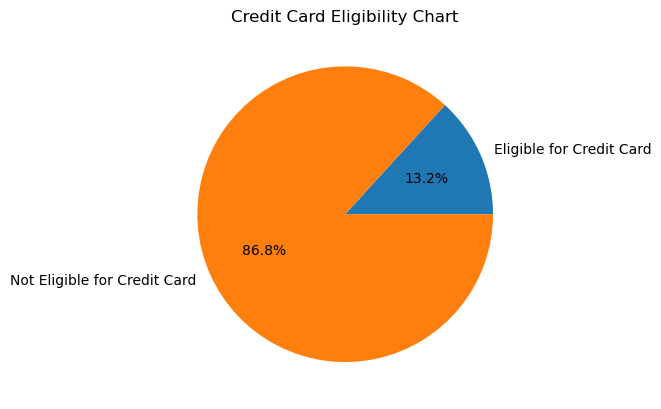

Percentage of individuals eligible for a credit card: 13.21%
How balanced is the target variable? 0.74


In [28]:
#Count the number of individuals who are eligible and not eligible for a credit card
target_counts = new_df['Target'].value_counts()
eligible_count = target_counts[1]
not_eligible_count = target_counts[0]
total_individuals = len(new_df)

# the distribution of individuals based on credit card eligibility
labels = ['Eligible for Credit Card', 'Not Eligible for Credit Card']
counts = [eligible_count, not_eligible_count]

#Number of Credit Card Eligible Persons
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Credit Card Eligibility Chart')
plt.show()

eligible_percentage = (eligible_count / total_individuals) * 100
balance = abs(eligible_count - not_eligible_count) / total_individuals

print(f"Percentage of individuals eligible for a credit card: {eligible_percentage:.2f}%")
print(f"How balanced is the target variable? {balance:.2f}")

In [29]:
# Drop irrevelant columns
new_df.drop(['ID', 'Num_family','Phone','Email','Unemployed'],axis=1)

,Gender,Own_car,Own_property,Work_phone,Num_children,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type,Target
0,1,1,1,1,0,15,427500.0,32.868574,12.435574,Working,Higher education,Civil marriage,Rented apartment,Other,1
1,1,1,1,0,0,29,112500.0,58.793815,3.104787,Working,Secondary / secondary special,Married,House / apartment,Security staff,0
2,0,0,1,0,0,4,270000.0,52.321403,8.353354,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,0
3,0,0,1,0,0,20,283500.0,61.504343,0.000000,Pensioner,Higher education,Separated,House / apartment,Other,0
4,1,1,1,1,0,5,270000.0,46.193967,2.105450,Working,Higher education,Married,House / apartment,Accountants,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9704,0,0,0,0,0,20,180000.0,56.400884,0.542106,Pensioner,Secondary / secondary special,Civil marriage,Municipal apartment,Laborers,1
9705,0,0,1,1,0,19,112500.0,43.360233,7.375921,Commercial associate,Secondary / secondary special,Married,House / apartment,Other,1
9706,1,1,1,0,0,21,90000.0,52.296762,4.711938,Working,Secondary / secondary special,Married,House / apartment,Other,1
9707,0,0,1,0,0,32,157500.0,33.914454,3.627727,Pensioner,Higher education,Married,House / apartment,Medicine staff,1


In [30]:
# Convert categorical features to numerical using LabelEncoder
le = LabelEncoder()
categorical_columns = ['Income_type', 'Education_type', 'Family_status', 'Housing_type',
       'Occupation_type']
for col in categorical_columns:
    new_df[col] = le.fit_transform(new_df[col])

In [31]:
# Load and preprocess data
# X = feature matrix, y = target variable (0 for not approved, 1 for approved)
X = new_df.drop('Target', axis=1)
y = new_df['Target']


In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the hyperparameter search space
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.1, 1],
}

# Create an SVM classifier
svm_classifier = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_classifier, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_svm_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("Accuracy on Test Set:", accuracy)

Best Hyperparameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Accuracy on Test Set: 0.8578784757981462


In [35]:
best_params = {
    'C': 0.1,
    'kernel': 'linear',
    'gamma': 0.01
}

best_svm_model = SVC(C=best_params['C'], kernel=best_params['kernel'], gamma=best_params['gamma'])

In [36]:
best_svm_model.fit(X_train, y_train)

SVC(C=0.1, gamma=0.01, kernel='linear')

In [37]:
y_pred = best_svm_model.predict(X_test)

In [38]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", accuracy)

Accuracy on Test Set: 0.8578784757981462


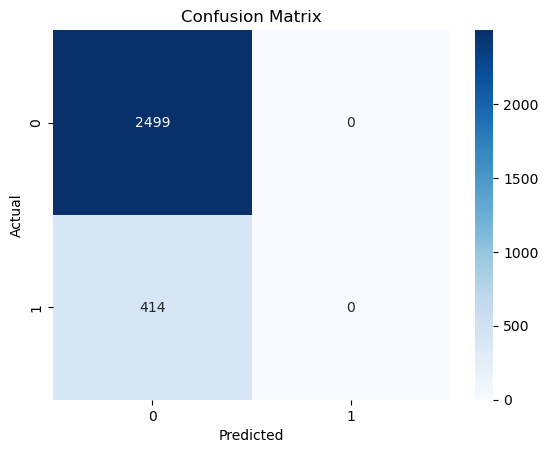

In [39]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()